In [2]:
# !pip install --user faker

In [1]:
from PIL import Image, ImageOps, ImageFilter, ImageChops
from IPython import display
import random

IMG = Image.open('./judgement2.jpg')

def random_image(img=IMG, size=(200, 100)):
    width, height = size
    sqrt2 = 2 ** .5
    regionsize = int(min(
        max(width, height) * sqrt2,
        min(img.size),
    ))
    inscribed = int(regionsize / sqrt2)
    x = random.randint(0, img.width - regionsize)
    y = random.randint(0, img.height - regionsize)
    subsection = img.crop([x, y, x+regionsize, y+regionsize])
    angle = random.randint(0, 360)
    rotated = subsection.rotate(angle)
    cropbox = [
    ]
    ratio = width / height
    if ratio > 1:
        cw, ch = inscribed, inscribed / ratio 
    else:
        cw, ch = inscribed * ratio, inscribed
    cropbox = (
        (regionsize-cw)/2, 
        (regionsize-ch)/2,
        (regionsize+cw)/2,
        (regionsize+ch)/2,
    )
    cropped = rotated.crop(cropbox)
    blur = ImageFilter.GaussianBlur(1)
    result = cropped.resize((width, height))
    enhanced = result.filter(blur)
    enhanced = random_bands(enhanced)
    blended = ImageChops.blend(result, enhanced, 0.5)
    blended = ImageChops.blend(blended, ImageOps.equalize(blended), 0.5)
    blended = blended.filter(blur)
    #blended =  ImageOps.equalize(blended)
    return blended 

def random_bands(img):
    r,g,b = img.split()
    bands = [r,g,b]
    dice = [True] * 2 + [False] * 3 
    random.shuffle(dice)
    if dice.pop():
        random.shuffle(bands)
    negbands = (ImageChops.invert(b) for b in bands)
    bands = [n if d else b for (b, n, d) in zip(bands, negbands, dice)]
    newimg = Image.merge('RGB', bands)
    newimg = ImageOps.equalize(newimg)
    return newimg



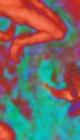
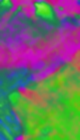
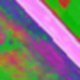
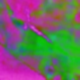
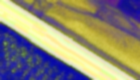
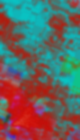
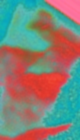
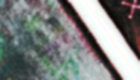
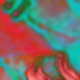
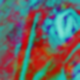
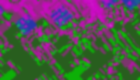
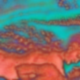
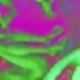
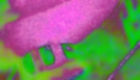
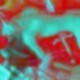
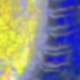
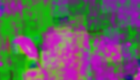
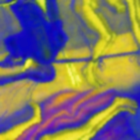
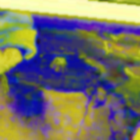
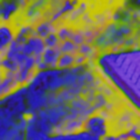
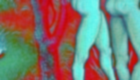
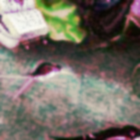
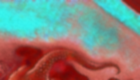
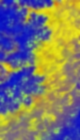
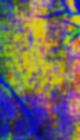
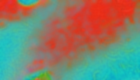
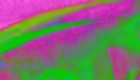
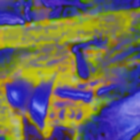
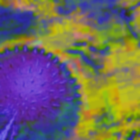
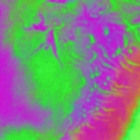
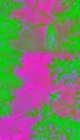
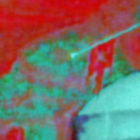
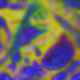
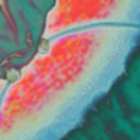
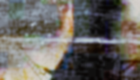
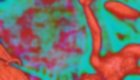
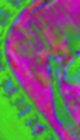
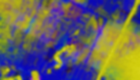
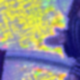
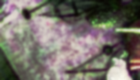
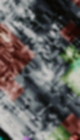
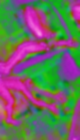
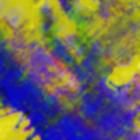
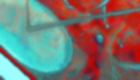
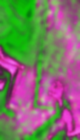
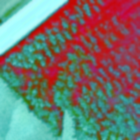
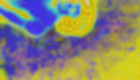
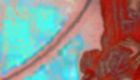
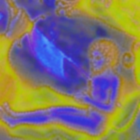
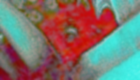

In [2]:
from io import BytesIO
import base64

def data_url(image):
    b = BytesIO()
    image.convert('RGB').save(b, 'PNG')
    raw = b.getvalue()
    data = base64.encodebytes(raw).decode('ascii').replace('\n', '')
    return 'data:image/png/;base64,{}'.format(data)

def image_to_html_img(image, style={}, **attrs):
    attrs['style'] = '{}'.format(';'.join('{}: {}'.format(*item) for item in style.items()))
    attrs['src'] = data_url(image)
    html = '<img {} />'.format(' '.join('{}="{}"'.format(*item) for item in attrs.items()))
    return html

def make_images(n=1, in_range=range(200,500,100)):
    choice = lambda: random.choice(in_range)
    images = (random_image(size=(choice(), choice())) for _ in range(n))
    style = {'display': 'inline-block', 'margin': '2px'}
    html = ''.join(image_to_html_img(img, style, title=img.size) for img in images)
    return display.HTML(html)

make_images(50, range(80, 200, 60))

In [3]:
from django.core.files import File
from faker import Factory
FAKE = Factory.create('no')

def fake_imagefile(size=(1200, 600), class_=ImageFile, fake=FAKE, **kwargs):
    image = random_image(size=size)
    blob = BytesIO()
    image.convert('RGB').save(blob, 'JPEG')
    filename = kwargs.pop('filename', fake.file_name(extension='jpg'))
    instance = class_(**kwargs)
    content = File(blob)
    instance.source_file.save(filename, content)
    return instance

def fake_contributor(fake=FAKE, **kwargs):
    name = fake.name()
    filename = '{}.jpg'.format(name).lower()
    byline_photo = fake_imagefile((400,400), ProfileImage, filename=filename)
    instance = Contributor(
        byline_photo = byline_photo,
        display_name = name,
        phone = fake.phone_number(),
        email = fake.email(),
        verified = True,
    )
    instance.save()
    return instance

In [4]:
def fake_story_image(story, byline):
    imagefile = fake_imagefile(contributor=byline)
    instance = StoryImage(
        parent_story = story,
        caption = 'foobar',
        imagefile = imagefile,
    )
    instance.save()
    return instance

In [5]:
def random_contributor():
    try:
        return Contributor.objects.order_by('?').first()
    except Contributor.DoesNotExist:
        fake_contributor()

def random_storytype():
    return StoryType.objects.order_by('?').first()

def fake_story_content(fake=FAKE):
    sections = "@tit:{title}", "@ing:{lede}", "@txt:{content}"
    title = fake.sentence(random.choice([1,2,3]))
    lede = ' '.join(fake.sentences(random.choice([1,2,3])))
    content = '\n'.join(fake.paragraphs(random.choice([4,5,10,20,30])))
    return '\n'.join(sections).format(title=title, lede=lede, content=content)


def fake_story():
    photo_by = random_contributor()
    text_by = random_contributor()
    markup = '{}\n@bl: text: {}\n@bl: photo:{}'.format(
        fake_story_content(), text_by, photo_by)
    
    print(markup)
    
    story = Story(
        story_type=random_storytype(),
        bodytext_markup=markup,
        publication_status = Story.STATUS_PUBLISHED,
        publication_date = timezone.now(),
    )
    story.save()
    numphotos = random.choice([0,1,1,3,5])
    for _ in range(numphotos):
        fake_story_image(story, photo_by)
    story.refresh_from_db()
    story.full_clean()
    story.frontpagestory_set.all().delete()
    story.save(new=True)
    return story

fake_story()

@tit:Aperiam fuga velit.
@ing:Provident neque iste est mollitia repellat. Nam ipsum nam eveniet aliquam odio minima. Rem illum fuga et et amet tempore.
@txt:Illo ipsam voluptatibus repudiandae placeat. Deleniti placeat sint ullam odio praesentium. Quidem cupiditate nisi dignissimos eos consequatur est nobis.
Exercitationem dolorem cupiditate tenetur iusto. Repellendus praesentium quod optio est.
Repudiandae doloribus est temporibus voluptate. Ratione autem repudiandae nisi adipisci commodi explicabo vero. Aliquam nihil facere nemo aspernatur consequuntur ipsa. Adipisci accusantium architecto asperiores perferendis reprehenderit magni.
Eveniet similique voluptatibus vel cumque sint fugiat adipisci. Libero atque numquam voluptatibus aspernatur rem qui ipsum. In quasi facilis odio veritatis.
Placeat dignissimos earum est vel natus quod quisquam. Saepe dolorum illum repellat nisi dolore voluptatum eligendi. Corrupti consequuntur ducimus soluta unde voluptates. Alias laboriosam quos reicien

<Story: 2017-02-08: Aperiam fuga velit.>

In [6]:
#Story.objects.all().delete()
#Contributor.objects.all().delete()
#[print(fake_contributor()) for n in range(20)]
[print(fake_story()) for n in range(50)]

@tit:Voluptate.
@ing:Repellat facilis quia culpa adipisci ea magni natus.
@txt:Deserunt voluptatum asperiores praesentium nemo exercitationem. Laudantium praesentium quis saepe corporis. In necessitatibus facere aliquid aliquam itaque.
Minima ipsa suscipit consequatur nam molestias quos rem veniam. Doloribus excepturi tenetur autem similique aut omnis debitis. Facere ipsum a recusandae repudiandae voluptatibus. A odio labore rem.
Sapiente error eum id porro mollitia quam. Sequi officiis unde accusamus enim nam neque modi. Tempora voluptatum in repellat nulla labore eligendi doloribus minima. Tenetur tenetur tempora nobis sunt maxime.
Sed debitis deserunt nemo animi. Quasi sequi sit culpa dolore sed. Itaque ducimus ut nam.
@bl: text: Britt Antonsen
@bl: photo:Dr. Håvard Christensen
2017-02-08: Voluptate.
@tit:Sed.
@ing:Repellendus maiores dicta voluptate ipsam iste. Nesciunt quos nesciunt maxime quo.
@txt:Doloremque non iste modi consectetur. Natus consequuntur quis mollitia odio. Fugia

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [9]:
import re
(re.L | re.I | re.M | re.LOCALE) & ~re.LOCALE

<RegexFlag.MULTILINE|IGNORECASE: 10>